In [1]:
#first load up low-res image
import dask.array as da

in_zarr = '/home/ROBARTS/alik/graham/scratch/3_processing/SPIMprep_LifeCanvas_fix/bids/sub-onuska23/micr/sub-onuska23_sample-brain_acq-prestitched_SPIM.ome.zarr.zip'

ds5 = da.from_zarr(in_zarr,component='5')
ds5


dask.array<from-zarr, shape=(2, 2137, 321, 232), dtype=uint16, chunksize=(1, 1, 321, 232), chunktype=numpy.ndarray>

In [2]:
import matplotlib.pyplot as plt

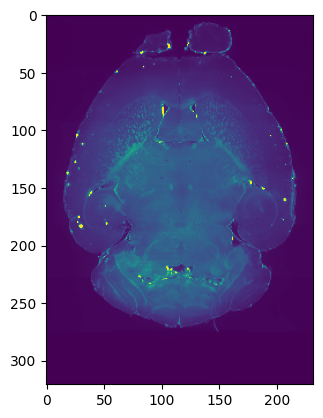

In [7]:
plt.imshow(ds5[1,1000,:,:],vmax=1000)

In [17]:
imslice = ds5[1,1000,:,:].compute()
flatim = imslice.flatten()
flatim.shape

(74472,)

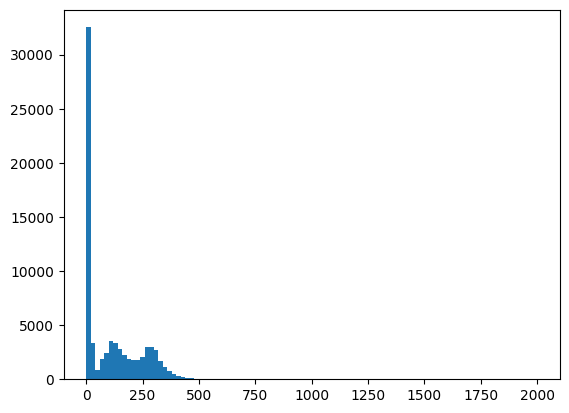

In [26]:
plt.hist(flatim,bins=100,range=(0,2000),log=False);

In [3]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

def get_matplotlib_colormap_with_transparent_background(colormap_name='Set1'):
    colormap_set1_original = plt.get_cmap(colormap_name)
    colors_colormap_set1_original = colormap_set1_original.colors
    new_colors = np.zeros(shape=(len(colors_colormap_set1_original) + 1, 4), dtype=float)
    new_colors[0, :] = 0  # set background transparent
    new_colors[1:, 3] = 1  # set alpha value

    # copy from original colormap
    for index, colors_colormap_set1_original in enumerate(colors_colormap_set1_original):
        new_colors[index + 1, 0:3] = colors_colormap_set1_original

    cmap_with_transparent_background = ListedColormap(new_colors)
    return cmap_with_transparent_background


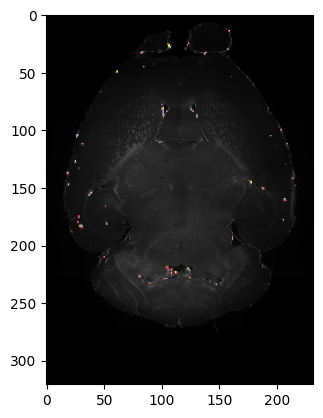

In [44]:
plt.imshow(imslice,cmap='gray',vmax=2000)
plt.imshow(imslice>800,cmap=get_matplotlib_colormap_with_transparent_background())

In [4]:
from math import sqrt
from skimage import data
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray

import matplotlib.pyplot as plt


ds = 3
image_gray = da.from_zarr(in_zarr,component=f'{ds}')[1,1000,:,:].compute()
#image_gray = np.clip(imslice,0,2000)

min_sigma_um = 10
max_sigma_um = 2000
raw_pix_um=1.8
ds_pix_um = raw_pix_um*(2**ds)
ds_pix_um

min_sigma_px = min_sigma_um / ds_pix_um
max_sigma_px = max_sigma_um / ds_pix_um

print(f'sigma from {min_sigma_px} to {max_sigma_px}')

threshold_rel=0.01
threshold_scaling=0.1

sigma from 0.6944444444444444 to 138.88888888888889
[(0, 10), (0, 10), (100, 110)]


In [158]:
#convert 
#max_sigma_px=30
#min_sigma_px=1
blobs_log = blob_log(image_gray, max_sigma=max_sigma_px, num_sigma=10, threshold=threshold_scaling*0.1)

# Compute radii in the 3rd column.
blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)

blobs_dog = blob_dog(image_gray, max_sigma=max_sigma_px, threshold=threshold_scaling*0.1)
blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)

blobs_doh = blob_doh(image_gray,  max_sigma=max_sigma_px, threshold=threshold_scaling*0.01)

blobs_list = [blobs_log, blobs_dog, blobs_doh]
colors = ['yellow', 'lime', 'red']
titles = ['Laplacian of Gaussian', 'Difference of Gaussian', 'Determinant of Hessian']
sequence = zip(blobs_list, colors, titles)

fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

for idx, (blobs, color, title) in enumerate(sequence):
    ax[idx].set_title(title)
    ax[idx].imshow(image_gray,vmax=1000)
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
        ax[idx].add_patch(c)
    ax[idx].set_axis_off()

plt.tight_layout()
plt.show()

fig.savefig('fig.png',dpi=300)

KeyboardInterrupt: 

In [106]:
blobs_doh = blob_doh(image_gray, min_sigma=min_sigma_px, max_sigma=max_sigma_px, threshold=0.000001)
blobs_doh.shape

(543, 3)

In [184]:
#compare blob_dog parameters:

#comparing sigmas -- 

threshold_scaling=0.1
min_sigmas_um = [1,10]
max_sigmas_um = [100,200]

#min_sigmas_um = [1,2]
#max_sigmas_um = [50,100]

N = len(min_sigmas_um)
M = len(max_sigmas_um)

blobs_list = []
titles = []

for i,min_sigma_um in enumerate(min_sigmas_um):
    for j,max_sigma_um in enumerate(max_sigmas_um):
        
        
        raw_pix_um=1.8
        ds_pix_um = raw_pix_um*(2**ds)
        ds_pix_um
        
        min_sigma_px = min_sigma_um / ds_pix_um
        max_sigma_px = max_sigma_um / ds_pix_um
        
        print(f'sigma from {min_sigma_px} to {max_sigma_px}')
        
        blobs_dog = blob_dog(image_gray, min_sigma=min_sigma_px, max_sigma=max_sigma_px, threshold=threshold_scaling*0.1)
        blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)
        blobs_list.append(blobs_dog)
        titles.append(f'DoG, sigmas=({min_sigma_um},{max_sigma_um})\n {len(blobs_dog)} blobs')
        

sigma from 0.06944444444444445 to 6.944444444444445
sigma from 0.06944444444444445 to 13.88888888888889
sigma from 0.6944444444444444 to 6.944444444444445
sigma from 0.6944444444444444 to 13.88888888888889


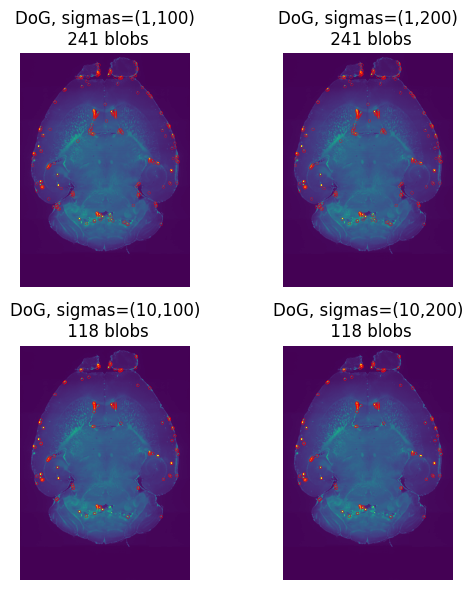

In [185]:
color = 'red'
sequence = zip(blobs_list, titles)

fig, axes = plt.subplots(N, M, figsize=(3*N, 3*M), sharex=True, sharey=True)
ax = axes.ravel()

for idx, (blobs, title) in enumerate(sequence):
    ax[idx].set_title(title)
    ax[idx].imshow(image_gray,vmax=1000)
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
        ax[idx].add_patch(c)
    ax[idx].set_axis_off()

plt.tight_layout()
plt.show()

fig.savefig('fig.png',dpi=300)

In [194]:
# frm above it appears sigma 1-100 (in microns) should work well
# now, below we see how the threshold affects the results

#compare blob_dog parameters:

#comparing sigmas -- 

#threshold_scaling=0.1
thresholds = [0.01,0.02,0.03,0.04,0.05,0.1,0.5]
min_sigma_um = 1
max_sigma_um = 100

#min_sigmas_um = [1,2]
#max_sigmas_um = [50,100]

N = len(thresholds)
M = 1

blobs_list = []
titles = []

for i,threshold in enumerate(thresholds):
                
        raw_pix_um=1.8
        ds_pix_um = raw_pix_um*(2**ds)
        ds_pix_um
        
        min_sigma_px = min_sigma_um / ds_pix_um
        max_sigma_px = max_sigma_um / ds_pix_um
        
        blobs_dog = blob_dog(image_gray, min_sigma=min_sigma_px, max_sigma=max_sigma_px, threshold=threshold)
        blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)
        blobs_list.append(blobs_dog)
        titles.append(f'DoG, sigmas=({min_sigma_um},{max_sigma_um})\n threshold={threshold}\n {len(blobs_dog)} blobs')
        print(f'min_sigma={min_sigma_um},max_sigma={max_sigma_um},threshold={threshold},blobs_detected={len(blobs_dog)}')

        

min_sigma=1,max_sigma=100,threshold=0.01,blobs_detected=241
min_sigma=1,max_sigma=100,threshold=0.02,blobs_detected=89
min_sigma=1,max_sigma=100,threshold=0.03,blobs_detected=65
min_sigma=1,max_sigma=100,threshold=0.04,blobs_detected=47
min_sigma=1,max_sigma=100,threshold=0.05,blobs_detected=41
min_sigma=1,max_sigma=100,threshold=0.1,blobs_detected=21
min_sigma=1,max_sigma=100,threshold=0.5,blobs_detected=0


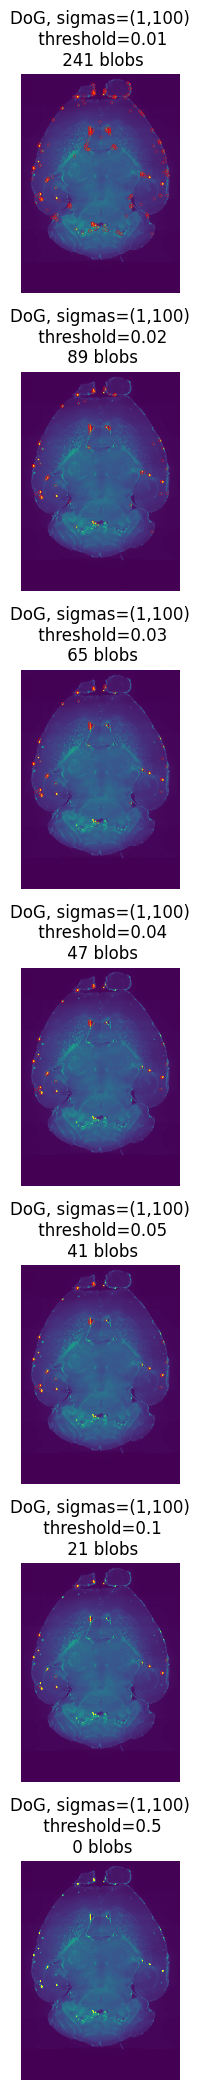

In [193]:
color = 'red'
sequence = zip(blobs_list, titles)

fig, axes = plt.subplots(N, M, figsize=(3*M, 3*N), sharex=True, sharey=True)
ax = axes.ravel()

for idx, (blobs, title) in enumerate(sequence):
    ax[idx].set_title(title)
    ax[idx].imshow(image_gray,vmax=1000)
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
        ax[idx].add_patch(c)
    ax[idx].set_axis_off()

plt.tight_layout()
plt.show()

fig.savefig('fig.png',dpi=300)

In [36]:
#threshold 0.02 seems to work well, now let's see how this does on higher-res images:


ds = 5
image_gray = da.from_zarr(in_zarr,component=f'{ds}')[1,900:1100,:,:].compute()
#image_gray = np.clip(imslice,0,2000)


#threshold_scaling=0.1
thresholds = [0.01,0.02,0.03,0.04,0.05,0.1,0.5]
thresholds = [0.02]
min_sigma_um = 1
max_sigma_um = 100

#min_sigmas_um = [1,2]
#max_sigmas_um = [50,100]

N = len(thresholds)
M = 1

blobs_list = []
titles = []

for i,threshold in enumerate(thresholds):
                
        raw_pix_um=1.8
        ds_pix_um = raw_pix_um*(2**ds)
        ds_pix_um
        
        min_sigma_px = min_sigma_um / ds_pix_um
        max_sigma_px = max_sigma_um / ds_pix_um
        
        blobs_dog = blob_dog(image_gray, min_sigma=min_sigma_px, max_sigma=max_sigma_px, threshold=threshold)
        blobs_dog[:, -1] = blobs_dog[:, -1] * sqrt(2)
        blobs_list.append(blobs_dog)
        titles.append(f'DoG, sigmas=({min_sigma_um},{max_sigma_um})\n threshold={threshold}\n {len(blobs_dog)} blobs')
        print(f'min_sigma={min_sigma_um},max_sigma={max_sigma_um},threshold={threshold},blobs_detected={len(blobs_dog)}')

        


min_sigma=1,max_sigma=100,threshold=0.02,blobs_detected=737


In [37]:
print(image_gray.shape)
blobs_dog

(200, 321, 232)


array([[ 65.        ,  26.        , 125.        ,   0.65907129],
       [170.        , 152.        ,  25.        ,   0.65907129],
       [ 40.        ,  27.        , 125.        ,   0.65907129],
       ...,
       [106.        , 221.        , 106.        ,   0.65907129],
       [ 34.        , 224.        , 132.        ,   0.65907129],
       [130.        ,  98.        , 202.        ,   0.65907129]])

In [39]:
blobs_dog.min(axis=0)

array([ 0.        , 17.        , 15.        ,  0.65907129])

In [ ]:
color = 'red'
sequence = zip(blobs_list, titles)

fig, axes = plt.subplots(N, M, figsize=(3*M, 3*N), sharex=True, sharey=True)
ax = axes.ravel()

for idx, (blobs, title) in enumerate(sequence):
    ax[idx].set_title(title)
    ax[idx].imshow(image_gray,vmax=1000)
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
        ax[idx].add_patch(c)
    ax[idx].set_axis_off()

plt.tight_layout()
plt.show()

fig.savefig(f'compare_thresholds_ds{ds}.png',dpi=300)

In [ ]:
#ok, now try on 3D data, using Dask
ds=5
abeta_chan = da.from_zarr(in_zarr,component=f'{ds}')[1,900:1100,:,:]
abeta_chan
#darr_labelled = darr[:,:,:].map_blocks(stardist_2d,dtype='uint8')
#darr_labelled = darr[800:801,:,:].map_blocks(stardist_2d,dtype='uint16')

min_sigma_um=1 
max_sigma_um=100
threshold=0.02 

#adjust sigma based on physical size of image
raw_pix_um=np.array((4,1.8,1.8))
ds_byax = np.array((1,2**ds,2**ds))
ds_um_per_pix = raw_pix_um*ds_byax
ds_um_per_pix

min_sigma_px = min_sigma_um / ds_um_per_pix
max_sigma_px = max_sigma_um / ds_um_per_pix
#abeta_chan = abeta_chan.rechunk((10,10,10))
abeta_chan

In [60]:
from dask.diagnostics import ProgressBar


def detect_blobs(x,block_info=None):

    #we need local chunk location in order to translate the local blob 
    #coords into global blob coords
    arr_location = block_info[0]['array-location']

    blobs_dog = np.array([0, 0,0, 1; 1, 2,3, 1;]
    #blobs_dog = blob_dog(x, min_sigma=min_sigma_px, max_sigma=max_sigma_px, threshold=threshold)
    #blobs_dog[:, -1] = blobs_dog[:, -1] * sqrt(2)

    #offset by chunk location
    for ax in range(3):
        blobs_dog[:,ax] = arr_location[ax][0] + blobs_dog[:,ax]
    
    #first just try with number of blobs
    return np.array(blobs_dog,ndmin=3)

SyntaxError: invalid syntax (2860852007.py, line 10)

In [61]:
darr_blobs = abeta_chan.map_blocks(detect_blobs,dtype='object', chunks=(1,1,1))


In [62]:
with ProgressBar():
    computed_blobs = darr_blobs.compute()

[                                        ] | 0% Completed | 5.90 s ms


KeyboardInterrupt: 

In [21]:
computed_blobs.shape

(1, 20, 33, 24)

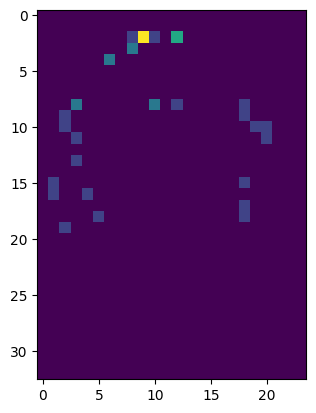

In [27]:
plt.imshow(computed_blobs[0,5,:,:])